In [43]:
# colab환경용
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-jrd4t2bd
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-jrd4t2bd
  Using cached torch-1.10.1-cp37-cp37m-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.10.1 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.10.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.10.1 which is incompatible.


In [46]:
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-r65a4gxy
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-r65a4gxy


In [48]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup


In [49]:
## CPU
#device = torch.device("cpu")

device = torch.device("cuda:0")

In [50]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [51]:
import pandas as pd
df = pd.read_csv('/content/홍대_맛집_리뷰_데이터_ver3.csv')
df.head()

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
0,0,후계동,4.5,풀내음,5.0,NaN,https://place.map.kakao.com/1183957472,2
1,1,후계동,4.5,ㅇㅇ,5.0,❤️❤️❤️❤️❤️,https://place.map.kakao.com/1183957472,2
2,2,후계동,4.5,핑구,5.0,오래 해주세요🙏,https://place.map.kakao.com/1183957472,2
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요… 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 ...,https://place.map.kakao.com/1183957472,1
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠! 너무맛있고 반찬 하나하나 다 맛있네요!! 자주 갈게요!,https://place.map.kakao.com/1183957472,2


In [52]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1227 non-null   int64  
 1   name            1227 non-null   object 
 2   average_rating  1227 non-null   float64
 3   user            1226 non-null   object 
 4   user_rating     1227 non-null   float64
 5   comment         957 non-null    object 
 6   url             1227 non-null   object 
 7   target          1227 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 76.8+ KB


In [53]:
df.duplicated(['comment'])

0       False
1       False
2       False
3       False
4       False
        ...  
1222    False
1223     True
1224    False
1225    False
1226    False
Length: 1227, dtype: bool

In [54]:
df.drop_duplicates(['comment'])

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
0,0,후계동,4.5,풀내음,5.0,NaN,https://place.map.kakao.com/1183957472,2
1,1,후계동,4.5,ㅇㅇ,5.0,❤️❤️❤️❤️❤️,https://place.map.kakao.com/1183957472,2
2,2,후계동,4.5,핑구,5.0,오래 해주세요🙏,https://place.map.kakao.com/1183957472,2
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요… 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 ...,https://place.map.kakao.com/1183957472,1
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠! 너무맛있고 반찬 하나하나 다 맛있네요!! 자주 갈게요!,https://place.map.kakao.com/1183957472,2
...,...,...,...,...,...,...,...,...
1221,1221,발바리네,4.6,리뷰저승사자,5.0,"6-7천원이면 매일매일 다르게 나오는 따뜻한 찌개들, 반찬들, 그리고 메인 반찬에서...",https://place.map.kakao.com/15625653,2
1222,1222,발바리네,4.6,그치,5.0,밥먹을때마다 행복합니다. 어느 반찬도 허투루가 없어요. 6000원짜리 제육볶음 상입...,https://place.map.kakao.com/15625653,2
1224,1224,발바리네,4.6,김태웅,5.0,이가격에 찌개랑 제육이 나오고 밥도 더주시는데 뭔말이 더 필요할까,https://place.map.kakao.com/15625653,2
1225,1225,발바리네,4.6,ㅇㅅㅇ,4.0,가성비짱,https://place.map.kakao.com/15625653,2


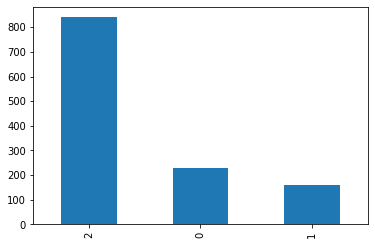

In [55]:
df['target'].value_counts().plot(kind = 'bar')

## 결측치 제거

In [56]:
df.isnull().sum()

Unnamed: 0          0
name                0
average_rating      0
user                1
user_rating         0
comment           270
url                 0
target              0
dtype: int64

In [57]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0        0
name              0
average_rating    0
user              0
user_rating       0
comment           0
url               0
target            0
dtype: int64

## 데이터 정제

In [58]:
df['comment'] = df['comment'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", '')

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
1,1,후계동,4.5,ㅇㅇ,5.0,,https://place.map.kakao.com/1183957472,2
2,2,후계동,4.5,핑구,5.0,오래 해주세요,https://place.map.kakao.com/1183957472,2
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,https://place.map.kakao.com/1183957472,1
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,https://place.map.kakao.com/1183957472,2
5,5,후계동,4.5,손민영,5.0,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,https://place.map.kakao.com/1183957472,2


In [59]:
df['comment'] = df['comment'].replace('', np.nan)
len(df)

956

In [60]:
df.isnull().sum()

Unnamed: 0        0
name              0
average_rating    0
user              0
user_rating       0
comment           3
url               0
target            0
dtype: int64

In [61]:
 # 정규표현식으로 인해 공백이 된 리뷰 행 제거
df = df.dropna()
len(df)

953

In [62]:
df.head(10)

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
2,2,후계동,4.5,핑구,5.0,오래 해주세요,https://place.map.kakao.com/1183957472,2
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,https://place.map.kakao.com/1183957472,1
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,https://place.map.kakao.com/1183957472,2
5,5,후계동,4.5,손민영,5.0,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,https://place.map.kakao.com/1183957472,2
6,6,후계동,4.5,장슐랭가이드,1.0,여기서 밥먹고 둘다 장염걸림,https://place.map.kakao.com/1183957472,0
7,7,후계동,4.5,이우진,5.0,최애 식당진짜 다 맛있고 가격이 엄청 착함오늘의 메뉴라고 매일 새로운 메뉴가 준비되...,https://place.map.kakao.com/1183957472,2
8,8,후계동,4.5,정찰병,4.0,다음부터 사장님 김치볶음밥하지마세요 ㅠ ㅜ 라면만 하세요하실꺼면 진짜 딴거말고 김치...,https://place.map.kakao.com/1183957472,2
9,9,후계동,4.5,쿠집사,5.0,이렇게 맛있어도 되나 할 정도로 맛있어요ㅎㅎ,https://place.map.kakao.com/1183957472,2
10,10,후계동,4.5,Sungjin Ji,5.0,오늘의 메뉴닭 카레라이스미니 어묵 우동둘 다 맛있다 카레는 일본식 아니고 우리식 우...,https://place.map.kakao.com/1183957472,2
11,11,후계동,4.5,손손,5.0,닭보쌈이 특히 예술 매일 해주시면 좋겠는데 오늘의메뉴여야 맛볼 수 있음,https://place.map.kakao.com/1183957472,2


In [63]:
df.drop(['Unnamed: 0', 'name', 'average_rating', 'user', 'user_rating', 'url'], axis=1, inplace=True)
df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,comment,target
2,오래 해주세요,2
3,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,1
4,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,2
5,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,2
6,여기서 밥먹고 둘다 장염걸림,0
7,최애 식당진짜 다 맛있고 가격이 엄청 착함오늘의 메뉴라고 매일 새로운 메뉴가 준비되...,2
8,다음부터 사장님 김치볶음밥하지마세요 ㅠ ㅜ 라면만 하세요하실꺼면 진짜 딴거말고 김치...,2
9,이렇게 맛있어도 되나 할 정도로 맛있어요ㅎㅎ,2
10,오늘의 메뉴닭 카레라이스미니 어묵 우동둘 다 맛있다 카레는 일본식 아니고 우리식 우...,2
11,닭보쌈이 특히 예술 매일 해주시면 좋겠는데 오늘의메뉴여야 맛볼 수 있음,2


In [64]:
df.reset_index(inplace = True)

In [65]:
df

,index,comment,target
0,2,오래 해주세요,2
1,3,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,1
2,4,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,2
3,5,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,2
4,6,여기서 밥먹고 둘다 장염걸림,0
...,...,...,...
948,1221,-천원이면 매일매일 다르게 나오는 따뜻한 찌개들 반찬들 그리고 메인 반찬에서는 불향...,2
949,1222,밥먹을때마다 행복합니다 어느 반찬도 허투루가 없어요 원짜리 제육볶음 상입니다 찌개도...,2
950,1224,이가격에 찌개랑 제육이 나오고 밥도 더주시는데 뭔말이 더 필요할까,2
951,1225,가성비짱,2


In [66]:
df.drop(['index'],axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,comment,target
0,오래 해주세요,2
1,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,1
2,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,2
3,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,2
4,여기서 밥먹고 둘다 장염걸림,0
...,...,...
948,-천원이면 매일매일 다르게 나오는 따뜻한 찌개들 반찬들 그리고 메인 반찬에서는 불향...,2
949,밥먹을때마다 행복합니다 어느 반찬도 허투루가 없어요 원짜리 제육볶음 상입니다 찌개도...,2
950,이가격에 찌개랑 제육이 나오고 밥도 더주시는데 뭔말이 더 필요할까,2
951,가성비짱,2


In [67]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.2, random_state=42)
print("train shape is:", len(train))
print("test shape is:", len(test))

train shape is: 762
test shape is: 191


In [68]:
train.to_csv('hongik_food_train.txt', index=False, sep="\t")
test.to_csv('hongik_food_test.txt', index=False, sep="\t")

In [69]:
dataset_train = nlp.data.TSVDataset("/content/hongik_food_train.txt", field_indices=[0,1], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("/content/hongik_food_test.txt", field_indices=[0,1], num_discard_samples=1)

## 토크나이저 선택

In [70]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [71]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [72]:
# Setting parameters
max_len = 150 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

## 데이터셋 생성

In [73]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [74]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 모델 생성

In [75]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [76]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [77]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [78]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [79]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [80]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [81]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [82]:
# 캐시지워주기

import torch, gc
gc.collect()
torch.cuda.empty_cache()


## 모델 학습

In [83]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  4%|▍         | 1/24 [00:00<00:19,  1.19it/s]

epoch 1 batch id 1 loss 1.1209123134613037 train acc 0.3125


100%|██████████| 24/24 [00:19<00:00,  1.21it/s]

epoch 1 train acc 0.5572916666666666



100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

epoch 1 test acc 0.6859879032258065



  4%|▍         | 1/24 [00:00<00:18,  1.24it/s]

epoch 2 batch id 1 loss 0.8427035212516785 train acc 0.625


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]

epoch 2 train acc 0.6393229166666666



100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

epoch 2 test acc 0.7227822580645161



  4%|▍         | 1/24 [00:00<00:17,  1.29it/s]

epoch 3 batch id 1 loss 0.8012669086456299 train acc 0.65625


100%|██████████| 24/24 [00:18<00:00,  1.28it/s]

epoch 3 train acc 0.6393229166666666



100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

epoch 3 test acc 0.7227822580645161



  4%|▍         | 1/24 [00:00<00:17,  1.29it/s]

epoch 4 batch id 1 loss 0.7034032344818115 train acc 0.6875


100%|██████████| 24/24 [00:18<00:00,  1.27it/s]

epoch 4 train acc 0.6825921474358975



100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

epoch 4 test acc 0.7750336021505376



  4%|▍         | 1/24 [00:00<00:18,  1.28it/s]

epoch 5 batch id 1 loss 0.6481497287750244 train acc 0.75


100%|██████████| 24/24 [00:19<00:00,  1.25it/s]

epoch 5 train acc 0.7732371794871794



100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

epoch 5 test acc 0.7852822580645161



  4%|▍         | 1/24 [00:00<00:18,  1.28it/s]

epoch 6 batch id 1 loss 0.43368998169898987 train acc 0.84375


100%|██████████| 24/24 [00:19<00:00,  1.25it/s]

epoch 6 train acc 0.8224158653846154



100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

epoch 6 test acc 0.8009072580645161



  4%|▍         | 1/24 [00:00<00:17,  1.28it/s]

epoch 7 batch id 1 loss 0.31247398257255554 train acc 0.90625


100%|██████████| 24/24 [00:19<00:00,  1.26it/s]

epoch 7 train acc 0.8487580128205128



100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

epoch 7 test acc 0.795866935483871



  4%|▍         | 1/24 [00:00<00:17,  1.29it/s]

epoch 8 batch id 1 loss 0.27592170238494873 train acc 0.90625


100%|██████████| 24/24 [00:18<00:00,  1.26it/s]

epoch 8 train acc 0.8578725961538461



100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

epoch 8 test acc 0.7384072580645161



  4%|▍         | 1/24 [00:00<00:17,  1.29it/s]

epoch 9 batch id 1 loss 0.2808837890625 train acc 0.90625


100%|██████████| 24/24 [00:19<00:00,  1.26it/s]

epoch 9 train acc 0.8669871794871794



100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

epoch 9 test acc 0.7906586021505376



  4%|▍         | 1/24 [00:00<00:18,  1.27it/s]

epoch 10 batch id 1 loss 0.20996041595935822 train acc 0.9375


100%|██████████| 24/24 [00:19<00:00,  1.26it/s]

epoch 10 train acc 0.8800080128205128



100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

epoch 10 test acc 0.8272849462365591
